# Display glacier area and thickness changes on a grid

In [2]:
from oggm import cfg
from oggm import tasks, utils, workflow, graphics, DEFAULT_BASE_URL
import xarray as xr
import matplotlib.pyplot as plt

This notebook proposes a method for redistributing glacier ice that has been simulated along the flowline after a glacier retreat simulation. Extrapolating the glacier ice onto a map involves certain assumptions and trade-offs. Depending on the purpose, different choices may be preferred. For example, higher resolution may be desired for visualization compared to using the output for a hydrological model. It is possible to add different options to the final function to allow users to select the option that best suits their needs.

This notebook demonstrates the redistribution process using a single glacier. Its purpose is to initiate further discussion before incorporating it into the main OGGM code base (currently, it is in the sandbox).

## Pick a glacier 

In [3]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level="WARNING")

# Local working directory (where OGGM will write its output)
# WORKING_DIR = utils.gettempdir('OGGM_distr4')
cfg.PATHS["working_dir"] = utils.get_temp_dir("OGGM_distributed", reset=True)

2024-03-19 16:01:02: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-03-19 16:01:02: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-03-19 16:01:02: oggm.cfg: Multiprocessing: using all available processors (N=10)


In [4]:
rgi_ids = ["RGI60-11.00106"]  # Pasterze
gdir = workflow.init_glacier_directories(
    rgi_ids, prepro_base_url=DEFAULT_BASE_URL, from_prepro_level=4, prepro_border=80
)[0]

2024-03-19 16:01:05: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2024-03-19 16:01:05: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


### Experiment: a random warming simulation

Here we use a random climate, but you can use any GCM, as long as glaciers are getting smaller, not bigger!

In [5]:
# Do a random run with a bit of warming
tasks.run_random_climate(
    gdir,
    ys=2020,
    ye=2100,  # Although the simulation is idealised, lets use real dates for the animation
    y0=2009,
    halfsize=10,  # Randome climate of 1999-2019
    seed=1,  # Random number generator seed
    temperature_bias=1.5,  # additional warming - change for other scenarios
    store_fl_diagnostics=True,  # important! This will be needed for the redistribution
    init_model_filesuffix="_spinup_historical",  # start from the spinup run
    output_filesuffix="_random_s1",  # optional - here I just want to make things explicit as to which run we are using afterwards
);

## Redistribute: preprocessing

The required tasks can be found in the `distribute_2d` module of the sandbox:

In [6]:
from oggm.sandbox import distribute_2d

In [7]:
# This is to add a new topography to the file (smoothed differently)
distribute_2d.add_smoothed_glacier_topo(gdir)
# This is to get the bed map at the start of the simulation
tasks.distribute_thickness_per_altitude(gdir)
# This is to prepare the glacier directory for the interpolation (needs to be done only once)
distribute_2d.assign_points_to_band(gdir)

Let's have a look at what we just did:

In [8]:
with xr.open_dataset(gdir.get_filepath("gridded_data")) as ds:
    ds = ds.load()

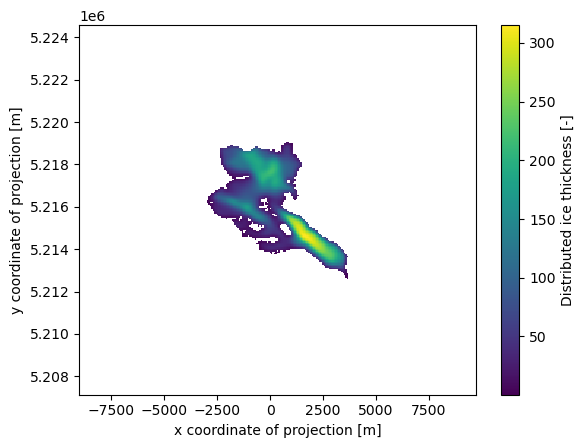

In [9]:
# Inititial glacier thickness
f, ax = plt.subplots()
ds.distributed_thickness.plot(ax=ax)
ax.axis("equal");

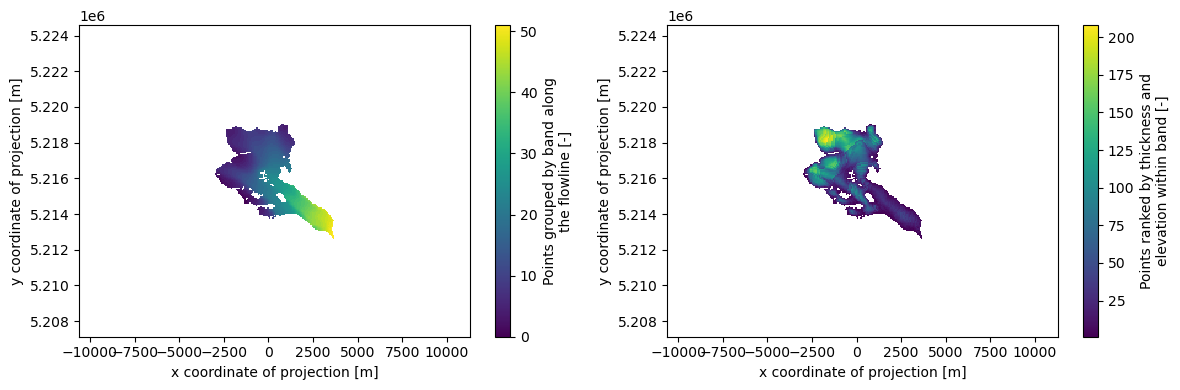

In [10]:
# Which points belongs to which band, and then within one band which are the first to melt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ds.band_index.plot(ax=ax1)
ds.rank_per_band.plot(ax=ax2)
ax1.axis("equal")
ax2.axis("equal")
plt.tight_layout();

## Redistribute simulation 

The tasks above need to be run only once. The next one however should be done for each simulation:

In [11]:
ds = distribute_2d.distribute_thickness_from_simulation(
    gdir,
    input_filesuffix="_random_s1",  # Use the simulation we just did
    concat_input_filesuffix="_spinup_historical",  # Concatenate with the historical spinup
)

## Plot 

Let's have a look!

In [12]:
# # This below is only to open the file again later if needed
# with xr.open_dataset(gdir.get_filepath('gridded_simulation', filesuffix='_random_s1')) as ds:
#     ds = ds.load()

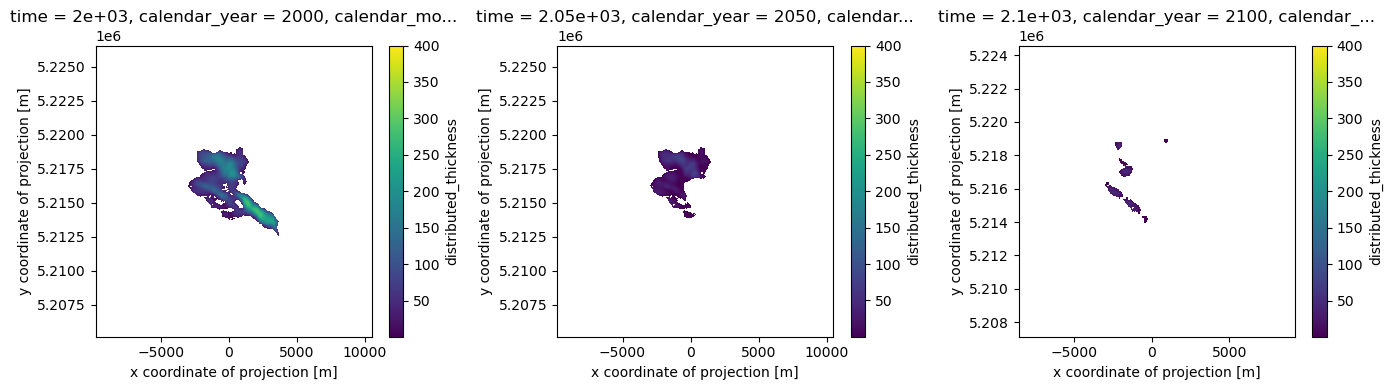

In [13]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
ds.distributed_thickness.sel(time=2000).plot(ax=ax1, vmax=400)
ds.distributed_thickness.sel(time=2050).plot(ax=ax2, vmax=400)
ds.distributed_thickness.sel(time=2100).plot(ax=ax3, vmax=400)
ax1.axis("equal")
ax2.axis("equal")
plt.tight_layout();

Note: the simulation before the RGI date cannot be trusted - it is the result of the dynamical spinup. Furthermore, if the area is larger than the RGI glacier, the redistribution algorithm will put all mass in the glacier mask, which is not what we want: 

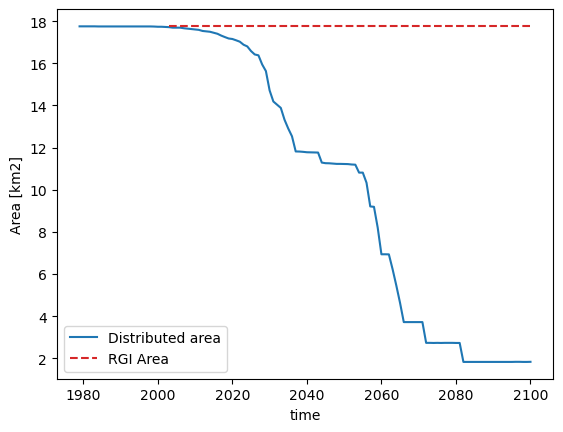

In [14]:
area = (ds.distributed_thickness > 0).sum(dim=["x", "y"]) * gdir.grid.dx**2 * 1e-6
area.plot(label="Distributed area")
plt.hlines(
    gdir.rgi_area_km2,
    gdir.rgi_date,
    2100,
    color="C3",
    linestyles="--",
    label="RGI Area",
)
plt.legend(loc="lower left")
plt.ylabel("Area [km2]");

Volume however is conserved:

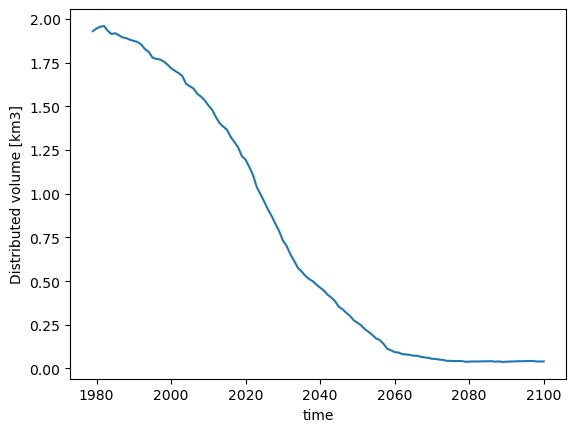

In [15]:
vol = ds.distributed_thickness.sum(dim=["x", "y"]) * gdir.grid.dx**2 * 1e-9
vol.plot(label="Distributed volume")
plt.ylabel("Distributed volume [km3]");

Therefore, lets just keep all data after the RGI year only:

In [16]:
ds = ds.sel(time=slice(gdir.rgi_date, None))

## Animation!

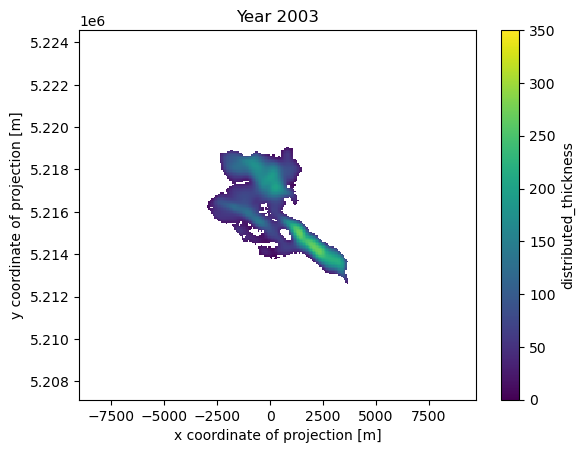

In [17]:
from matplotlib import animation
from IPython.display import HTML, display

# Get a handle on the figure and the axes
fig, ax = plt.subplots()

thk = ds["distributed_thickness"]

# Plot the initial frame.
cax = thk.isel(time=0).plot(
    ax=ax,
    add_colorbar=True,
    cmap="viridis",
    vmin=0,
    vmax=350,
    cbar_kwargs={"extend": "neither"},
)
ax.axis("equal")


def animate(frame):
    ax.set_title(f"Year {int(thk.time[frame])}")
    cax.set_array(thk.values[frame, :].flatten())


ani_glacier = animation.FuncAnimation(fig, animate, frames=len(thk.time), interval=100);

In [18]:
HTML(ani_glacier.to_jshtml())

In [ ]:
# Write to mp4?
# FFwriter = animation.FFMpegWriter(fps=10)
# ani2.save('animation.mp4', writer=FFwriter)

## Finetune the visualisation 

When applying the tools you might see that sometimes the timeseries are "shaky", or have sudden changes in area. This comes from a few reasons:
- OGGM does not distinguish between ice and snow, i.e. when it snows a lot sometimes OGGM thinks there is a glacier for a couple of years.
- the trapezoidal flowlines result in sudden ("step") area changes when they melt entirely. 
- on small glaciers, the changes within one year can be big, and you may want to have more intermediate frames

We implement some workarounds for these situations:

In [ ]:
ds_smooth = distribute_2d.distribute_thickness_from_simulation(
    gdir,
    input_filesuffix="_random_s1",
    concat_input_filesuffix="_spinup_historical",
    ys=2003,
    ye=2100,  # make the output smaller
    output_filesuffix="_random_s1_smooth",  # do not overwrite the previous file (optional)
    # add_monthly=True,  # more frames! (12 times more - we comment for the demo, but recommend it)
    rolling_mean_smoothing=7,  # smooth the area time series
    fl_thickness_threshold=1,  # avoid snow patches to be nisclassified
)

In [ ]:
area = (ds.distributed_thickness > 0).sum(dim=["x", "y"]) * gdir.grid.dx**2 * 1e-6
area.plot(label="Distributed area (raw)")
area = (
    (ds_smooth.distributed_thickness > 0).sum(dim=["x", "y"]) * gdir.grid.dx**2 * 1e-6
)
area.plot(label="Distributed area (smooth)")
plt.legend(loc="lower left")
plt.ylabel("Area [km2]");

In [ ]:
# Get a handle on the figure and the axes
fig, ax = plt.subplots()

thk = ds_smooth["distributed_thickness"]

# Plot the initial frame.
cax = thk.isel(time=0).plot(
    ax=ax,
    add_colorbar=True,
    cmap="viridis",
    vmin=0,
    vmax=350,
    cbar_kwargs={"extend": "neither"},
)
ax.axis("equal")


def animate(frame):
    ax.set_title(f"Year {float(thk.time[frame]):.1f}")
    cax.set_array(thk.values[frame, :].flatten())


ani_glacier = animation.FuncAnimation(fig, animate, frames=len(thk.time), interval=100);

In [ ]:
# Visualize
HTML(ani_glacier.to_jshtml())

In [ ]:
# Write to mp4?
# FFwriter = animation.FFMpegWriter(fps=120)
# ani2.save('animation_smooth.mp4', writer=FFwriter)

## Nice 3D videos 

We are working on a tool to make even nicer videos like this one:

In [ ]:
from IPython.display import Video

Video("../../img/mittelbergferner.mp4", embed=True, width=700)

The WIP tool is available here: https://github.com/OGGM/oggm-3dviz